**Importing the libraries**

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
import matplotlib.pyplot as plt

Using TensorFlow backend.


**Processing and cleaning the data**

In [2]:
pd.set_option('display.max_columns', 80)
# load the data (5 samples to clean and concatenate)
f0 = pd.read_csv('/home/teresas/csv_files/craftworks/2016_02_22_152956_Problem4_1_3.xlsx_7a_7.csv', delimiter = ';')
f1 = pd.read_csv('/home/teresas/csv_files/craftworks/2015_11_07_204622_Problem4_1_5b.xlsx_8a_8.csv', delimiter = ';')
f2 = pd.read_csv('/home/teresas/csv_files/craftworks/2015_06_15_060759_Problem4_1_3.xlsx_4a_4.csv', delimiter = ';')
f3 = pd.read_csv('/home/teresas/csv_files/craftworks/2015_06_08_014843_Problem4_1_10a.xlsx_3a_3.csv', delimiter = ';')
f4 = pd.read_csv('/home/teresas/csv_files/craftworks/2015_04_21_190048_Problem4_1_3.xlsx_1a_1.csv', delimiter = ';')

In [3]:
# data pre processing
a = [f0, f1, f2, f3, f4]
b = [0] * 5
c = [0] * 5
join = [0] * 5
for i, e in enumerate(a):
    # dropping non number, low diversity and NaN elements columns
    a[i] = e.drop(['Customer', 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var9', 'var14', 'var15',
                   'var19', 'var20', 'var31', 'var32', 'var33', 'var34', 'var35', 'var38', 'var39',
                   'var40', 'var46', 'var48', 'var61', 'var62', 'var63', 'var64', 'var69', 'var74', 'var77'], axis=1)
    # normal data (pre sheet break) classified as 0
    b[i] = a[i].ix[0:240]      
    b[i]['class'] = b[i]['var8'].map(lambda x: 0)
    # sheet break data classified as 1
    c[i] = a[i].ix[5640:5760]  
    c[i]['class'] = c[i]['var8'].map(lambda x: 1)
    join[i] = b[i].append(c[i])
# concatenate the cleaned data
df_all = pd.concat(join)
print(df_all.shape)
# save the pre processed dataframe
df_all.to_csv('df_all.csv')    

/home/teresas/anaconda3/envs/py_3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/teresas/anaconda3/envs/py_3.5.2/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(1810, 49)


**Deep Learning approach model using a DNN archtecture**

In [4]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load the pre processed dataset
df = pd.read_csv('df_all.csv', delimiter = ',')
df = df.drop(['Unnamed: 0'], axis=1) # drop columns
df = df.astype('float32')
dataset = df.values
# split into input (X) and output (Y) variables
X = dataset[:,0:48]
Y = dataset[:,48]
print(X.shape, Y.shape)

(1810, 48) (1810,)


In [5]:
# the data array
X

array([[ 187.07556152,   72.49732208,  234.44749451, ...,  186.21679688,
           1.06143844,   49.03845978],
       [ 187.10328674,   72.48682404,  236.22302246, ...,  186.21679688,
           1.06143844,   49.        ],
       [ 187.1309967 ,   72.45169067,  235.17184448, ...,  186.21679688,
           1.06143844,   50.        ],
       ..., 
       [ 182.95672607,   76.11055756,  337.78833008, ...,  185.01626587,
           1.04548264,   49.        ],
       [ 182.93096924,   76.00006104,  340.22525024, ...,  185.02052307,
           1.04548895,   48.66666794],
       [ 182.9052124 ,   75.94516754,  338.26010132, ...,  185.02476501,
           1.04549527,    2.        ]], dtype=float32)

In [6]:
# the classification array (0 = normal condictions, 1 = possible sheet break condictions)
Y

array([ 0.,  0.,  0., ...,  1.,  1.,  1.], dtype=float32)

**DNN archtecture**

In [7]:
# We create a Sequential model and add layers one at a time until we are happy with our network topology.
model = Sequential()
# input layer
model.add(Dense(48, input_dim=48, kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# hidden layer 1
model.add(Dense(32, kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))          
# output layer          
model.add(Dense(1, kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
# compile
sgd = SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

**Fit the model using 33% of the data as validation**

In [8]:
# Fit the model 
history = model.fit(X, Y, validation_split=0.33, epochs=100, batch_size=10, verbose=1)
scores = model.evaluate(X, Y)
print(" %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Train on 1212 samples, validate on 598 samples
Epoch 1/100
1212/1212 [==============================] - 1s - loss: 0.5446 - acc: 0.7797 - val_loss: 1.1368 - val_acc: 0.5953

**Plotting the loss function**

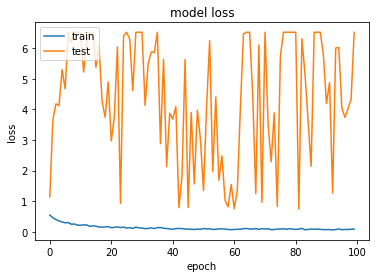

In [9]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Conclusion:** The loss function looks like a random variable after many modifications of the model parameters. My conclusion is that the inputs (original data) are not correlated in a way that differs significantly of random inputs behavior.

**Possible Solution:** Try another set of input data that is more sensible to sheet break behavior.